In [1]:
import pandas as pd

from tabular.pipeline import *
from tabular.experiments import *
from researcher.records import *

import matplotlib.pyplot as plt

In [17]:
trn = pd.read_csv("data/train.csv")


In [18]:
subset = trn.sample(3000).reset_index()

In [2]:
def agg_proc(group_cols, agg_col, aggs):
    def aggregated(df, trn_idx, targets):
        if agg_col in targets:
            stats_df = df.iloc[trn_idx]
        else:
            stats_df = df

        grouped = stats_df[group_cols + [agg_col]].groupby(group_cols)
        
        for agg in aggs:
            agg_name = agg_col + "_" + agg
            agg = grouped.agg(agg)
            print(agg)
            agg = agg.rename({agg_col: "-".join(group_cols) + "_wise_" + agg_name}, axis=1)
            print(agg)

            merge = pd.merge(df, agg, on=group_cols, suffixes=("", ""))
            
        return merge, trn_idx
    
    return aggregated

In [3]:
bid_mean_enc = agg_proc(["building_id"], "meter_reading", ["mean"])
bid_meter_mean_enc = agg_proc(["building_id", "meter"], "meter_reading", ["mean"])

In [6]:
PIPELINES["bid_mean_enc"] = Pipeline([bid_mean_enc, bid_meter_mean_enc], [])

In [7]:
params = {
    "title": "test",
    "notes": " some human readable sentence",
    "experiment": "linear_reg",
    "data_name": "data/train.csv",
    "folds": 5,
    "pipeline": "bid_mean_enc",
    "metrics": ["mse"],
    "x_cols": ["building_id_wise_meter_reading_mean", "building_id-meter_wise_meter_reading_mean", "meter"],
    "y_cols": ["meter_reading"],
}

In [8]:
res = run_experiment(params, "records/")

             meter_reading
building_id               
0               146.454978
1                74.865393
2                14.551385
3               235.549966
4               976.556746
...                    ...
1444              7.482127
1445              4.732815
1446              3.592162
1447            187.117994
1448              3.338595

[1449 rows x 1 columns]
             building_id_wise_meter_reading_mean
building_id                                     
0                                     146.454978
1                                      74.865393
2                                      14.551385
3                                     235.549966
4                                     976.556746
...                                          ...
1444                                    7.482127
1445                                    4.732815
1446                                    3.592162
1447                                  187.117994
1448                                

             meter_reading
building_id               
0               146.454978
1                74.865393
2                14.551385
3               235.549966
4               976.556746
...                    ...
1444              7.482127
1445              4.732815
1446              3.592162
1447            187.117994
1448              3.338595

[1449 rows x 1 columns]
             building_id_wise_meter_reading_mean
building_id                                     
0                                     146.454978
1                                      74.865393
2                                      14.551385
3                                     235.549966
4                                     976.556746
...                                          ...
1444                                    7.482127
1445                                    4.732815
1446                                    3.592162
1447                                  187.117994
1448                                

In [10]:
res.get_metric("mse")

[[128761.22000527076],
 [10353.177066869473],
 [54047464.93658471],
 [85748242963.67863],
 [708384.7359607856]]

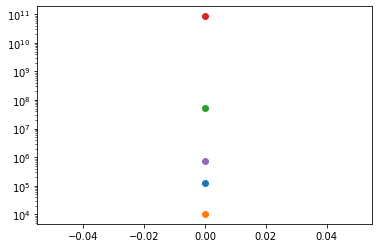

In [14]:
res = past_experiment_from_hash("records/", "ec82757157dc").results
fig, ax = plt.subplots()
ax.set_yscale("log")


for fold in res.get_metric("mse"):
    ax.scatter(0, fold)

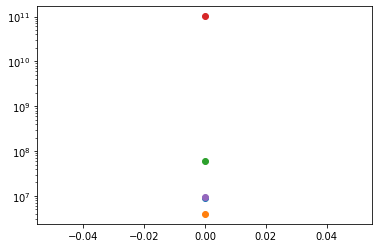

In [12]:
res = past_experiment_from_hash("records/", "262dc6ffbad").results
fig, ax = plt.subplots()
ax.set_yscale("log")


for fold in res.get_metric("mse"):
    ax.scatter(0, fold)

[[18899806900.366104],
 [65922637417.14631],
 [29483771984.313713],
 [73728779.50177501],
 [3029002638.4022694]]

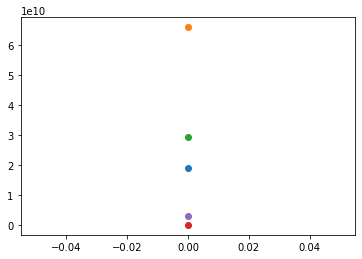

In [9]:


_, ax = plt.subplots()
for fold in res.results.get_metric("mse"):
    ax.scatter(0, fold)